<a href="https://colab.research.google.com/github/AryanMethil/Mask-Detection/blob/master/Mask_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Image Augmentation

In [4]:
train_dir='/content/drive/My Drive/Mask_Datasets/Train'
validation_dir='/content/drive/My Drive/Mask_Datasets/Validation'

In [5]:
train_data_gen=ImageDataGenerator(rescale=1/255,
                                  rotation_range=30,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0.6,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
validation_data_gen=ImageDataGenerator(rescale=1/255)


In [6]:
train_generator=train_data_gen.flow_from_directory(train_dir,
                                   target_size=(150,150),
                                   batch_size=16,
                                   class_mode='binary',shuffle=True)
validation_generator=validation_data_gen.flow_from_directory(validation_dir,
                                                             batch_size=16,
                                                             target_size=(150,150),
                                                             class_mode='binary',shuffle=True)

Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [14]:
print(validation_generator.class_indices)

{'Mask': 0, 'No_mask': 1}


# Visualisation of ResNet Model

In [15]:
resnet_model = tf.keras.applications.ResNet101V2(include_top=False, weights = 'imagenet', input_shape=(150,150,3))

171319296/171317808 [==============================] - 1s 0us/step


In [21]:
conv_layers = [layer for layer in resnet_model.layers if '_conv' in str(layer.name)]
num_conv_layers = len(conv_layers)
selected_conv_layers = [conv_layers[i] for i in [0,12,25,38,51,64,77,90,103]]
selected_conv_layers

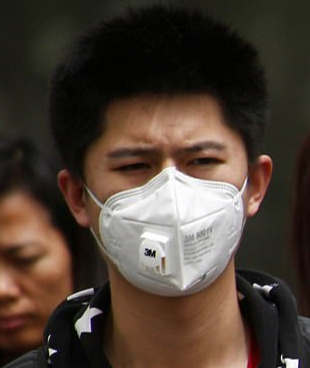

In [22]:
img_path = '/content/drive/MyDrive/Mask-Detection/Mask_Datasets/Train/Mask/122.PNG'
img = Image.open(img_path)
img

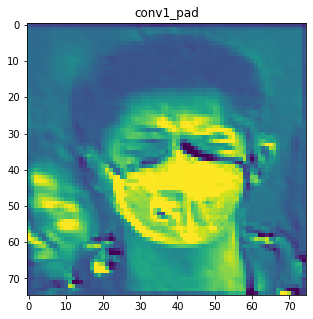

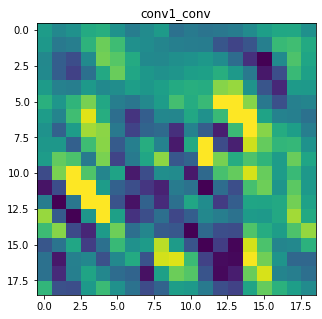

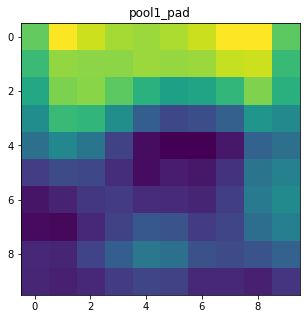

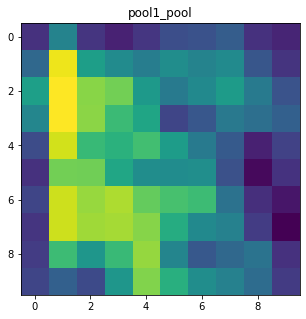

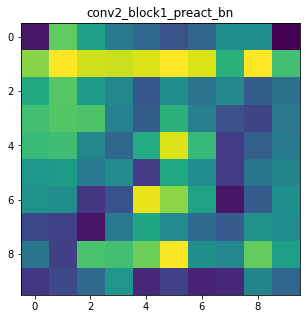

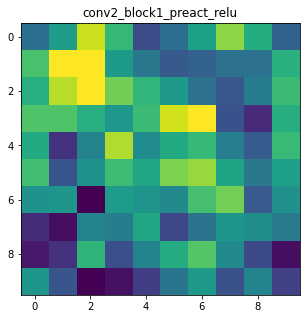

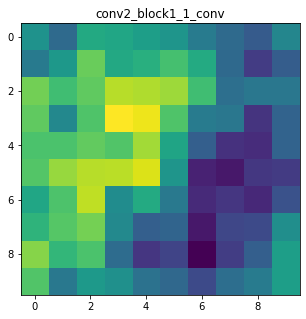

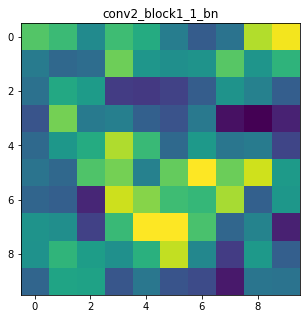

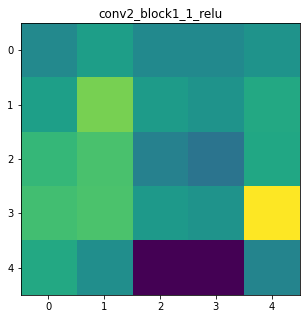

In [24]:
successive_outputs = [layer.output for layer in selected_conv_layers]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = resnet_model.input, outputs = successive_outputs)


img = load_img(img_path, target_size=(150,150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in resnet_model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = 1  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    i = random.randint(0, feature_map.shape[-1])
    # Postprocess the feature to make it visually palatable
    x = feature_map[0, :, :, i]
    x -= x.mean()
    x /= x.std()
    x *= 64
    x += 128
    x = np.clip(x, 0, 255).astype('uint8')
    # We'll tile each filter into this big horizontal grid
    display_grid[:, 0 : size] = x
  # Display the grid
    scale = 5. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Model

In [3]:
base_model=tf.keras.applications.ResNet101V2(include_top=False,weights='imagenet',input_shape=(150,150,3))
base_model.trainable=False
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

171319296/171317808 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 55,734,273
Trainable params: 13,107,713
Non-trainable params: 42,626,560
_________________________________________________________________


In [5]:
model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs['accuracy']>=0.99):
      self.model.stop_training=True
callbacks=myCallback()


In [11]:
epochs=100
history=model.fit(train_generator,epochs=epochs,steps_per_epoch=47,callbacks=[callbacks],validation_data=validation_generator)

Epoch 1/100
47/47 [==============================] - 595s 12s/step - loss: 2.6946 - accuracy: 0.8886 - val_loss: 0.6039 - val_accuracy: 0.9914
Epoch 2/100
47/47 [==============================] - 31s 663ms/step - loss: 1.3101 - accuracy: 0.9608 - val_loss: 0.5833 - val_accuracy: 0.9914
Epoch 3/100
47/47 [==============================] - 31s 658ms/step - loss: 0.7773 - accuracy: 0.9735 - val_loss: 0.6880 - val_accuracy: 0.9886
Epoch 4/100
47/47 [==============================] - 31s 664ms/step - loss: 0.5107 - accuracy: 0.9859 - val_loss: 0.4993 - val_accuracy: 0.9914
Epoch 5/100
47/47 [==============================] - 31s 664ms/step - loss: 0.2981 - accuracy: 0.9932 - val_loss: 0.4585 - val_accuracy: 0.9886


In [34]:
model.save('face_mask_model.h5')

# Plot Results

Text(0.5, 1.0, 'Training and validation loss')

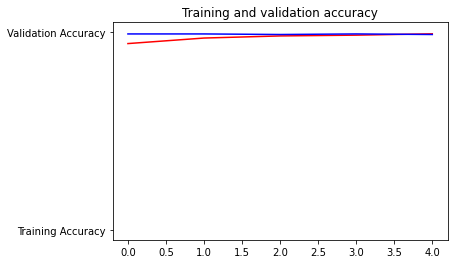

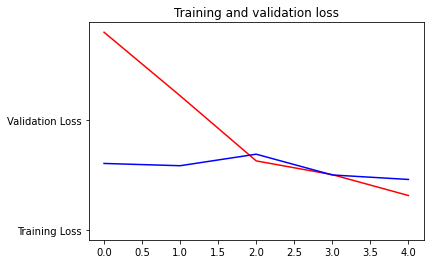

In [12]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


In [28]:
model.evaluate(validation_generator)

22/22 [==============================] - 10s 454ms/step - loss: 0.4585 - accuracy: 0.9886


[0.4584594666957855, 0.9885714054107666]